In [12]:
# loading and pre-processing data
import os
import cv2
categories = ["yes","no"]
datadir ='E:/project/BTD1'
dataset = []
img_size = 150

for category in categories:
    path = os.path.join(datadir,category)
    class_num = categories.index(category)

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array,(img_size,img_size))
            dataset.append([new_array,class_num])
        except Exception as e:
            pass

print("Total images ->",len(dataset))


Total images -> 302


In [13]:
# re-shaping and normalizing

import numpy as np

X = []
y = []

for features,label in dataset:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,img_size,img_size,1)
X = X/255.0
y = np.array(y).reshape(-1,1)

print("Dimension of input features ->",X.shape)
print("Dimension of output labels ->",y.shape)


Dimension of input features -> (302, 150, 150, 1)
Dimension of output labels -> (302, 1)


In [14]:
# split the dataset into train_test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print("X_train shape ->",X_train.shape)
print("X_test shape ->",X_test.shape)
print("y_train shape ->",y_train.shape)
print("y_test shape ->",y_test.shape)

X_train shape -> (241, 150, 150, 1)
X_test shape -> (61, 150, 150, 1)
y_train shape -> (241, 1)
y_test shape -> (61, 1)


In [15]:
# building model architecture

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from keras.optimizers import Adam

model = Sequential()

# 1st conv layer block
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'same', activation ='relu', 
                 input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 2nd conv layer block
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

# 3rd conv layer block
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 4th conv layer block
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 5th conv layer block
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fullly-connected layers
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))

# compiling the model
model.compile(optimizer = 'adam' , loss = "binary_crossentropy",metrics=["accuracy"])

In [16]:
# training the model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
checkpoint_path = "brain_tumor.h5"  
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      save_brain_only=True,
                                      save_weights_only=True,
                                      verbose=1)


history = model.fit(
    X_train,y_train,
    batch_size = 20,
    epochs =30, 
    validation_split = 0.2
)
# save the model
model.save("brain_tumor.h5")


Epoch 1/30
10/10 [==============================] - 116s 5s/step - loss: 0.7084 - accuracy: 0.5469 - val_loss: 0.6871 - val_accuracy: 0.5306
Epoch 2/30
10/10 [==============================] - 27s 3s/step - loss: 0.6970 - accuracy: 0.5260 - val_loss: 0.6842 - val_accuracy: 0.5714
Epoch 3/30
10/10 [==============================] - 26s 3s/step - loss: 0.6557 - accuracy: 0.5885 - val_loss: 0.6094 - val_accuracy: 0.6531
Epoch 4/30
10/10 [==============================] - 25s 3s/step - loss: 0.5506 - accuracy: 0.7500 - val_loss: 0.5776 - val_accuracy: 0.6939
Epoch 5/30
10/10 [==============================] - 18s 2s/step - loss: 0.5234 - accuracy: 0.7656 - val_loss: 0.4854 - val_accuracy: 0.6939
Epoch 6/30
10/10 [==============================] - 24s 2s/step - loss: 0.4289 - accuracy: 0.7812 - val_loss: 0.4473 - val_accuracy: 0.7755
Epoch 7/30
10/10 [==============================] - 62s 7s/step - loss: 0.3604 - accuracy: 0.8385 - val_loss: 0.5391 - val_accuracy: 0.7755
Epoch 8/30
10/10 [=

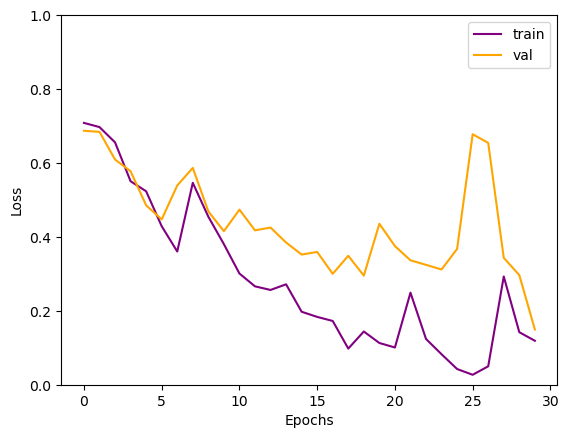

In [17]:
# plotting training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.ylim([0,1])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

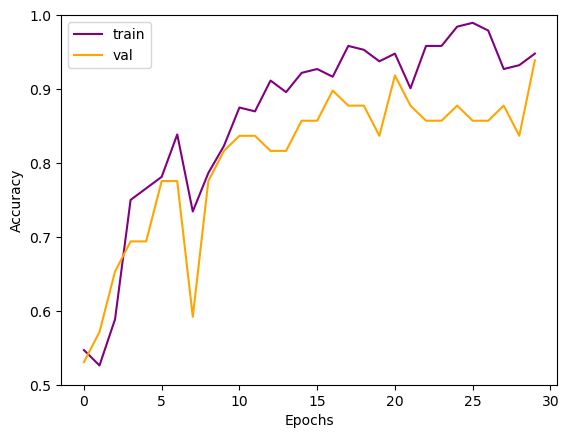

In [18]:
# plotting training and validation accuracy
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

In [19]:
# evaluating the model on test dataset

import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

loss, accuracy = model.evaluate(X_test,y_test,verbose=0)

y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')
print(f'Test precision: {precision:.4f}')
print(f'Test recall: {recall:.4f}')
print(f'Test F1 score: {f1:.4f}')

2/2 [==============================] - 11s 382ms/step
Test loss: 0.6754
Test accuracy: 0.8689
Test precision: 0.8235
Test recall: 0.9333
Test F1 score: 0.8750


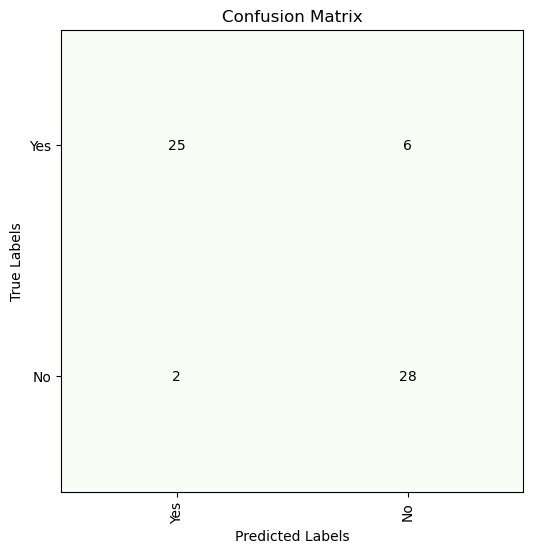

In [20]:
# plotting the confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix')
plt.imshow(conf_matrix, cmap=plt.cm.Greens,vmin=240,vmax=370)

tick_marks = range(conf_matrix.shape[0])
classes = ['Yes', 'No']
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(0,2):
    for j in range(0,2):
        plt.text(
            j, i, str(conf_matrix[i][j]),
            horizontalalignment="center",
            verticalalignment="center"
        )

In [21]:
# loading and pre-processing unlabelled images
datadir ='E:/project/BTD1'
path = os.path.join(datadir,'pred')
X_new = []
img_size = 150


for img in os.listdir(path):
    try:
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(img_size,img_size))
        X_new.append(new_array)
    except Exception as e:
        pass

X_new = np.array(X_new).reshape(-1,img_size,img_size,1)
X_new = X_new/255.0

print("Total unlabelled images ->",len(X_new))
print("Dimensions after pre-processing ->",X_new.shape)

Total unlabelled images -> 60
Dimensions after pre-processing -> (60, 150, 150, 1)


2/2 [==============================] - 3s 2s/step


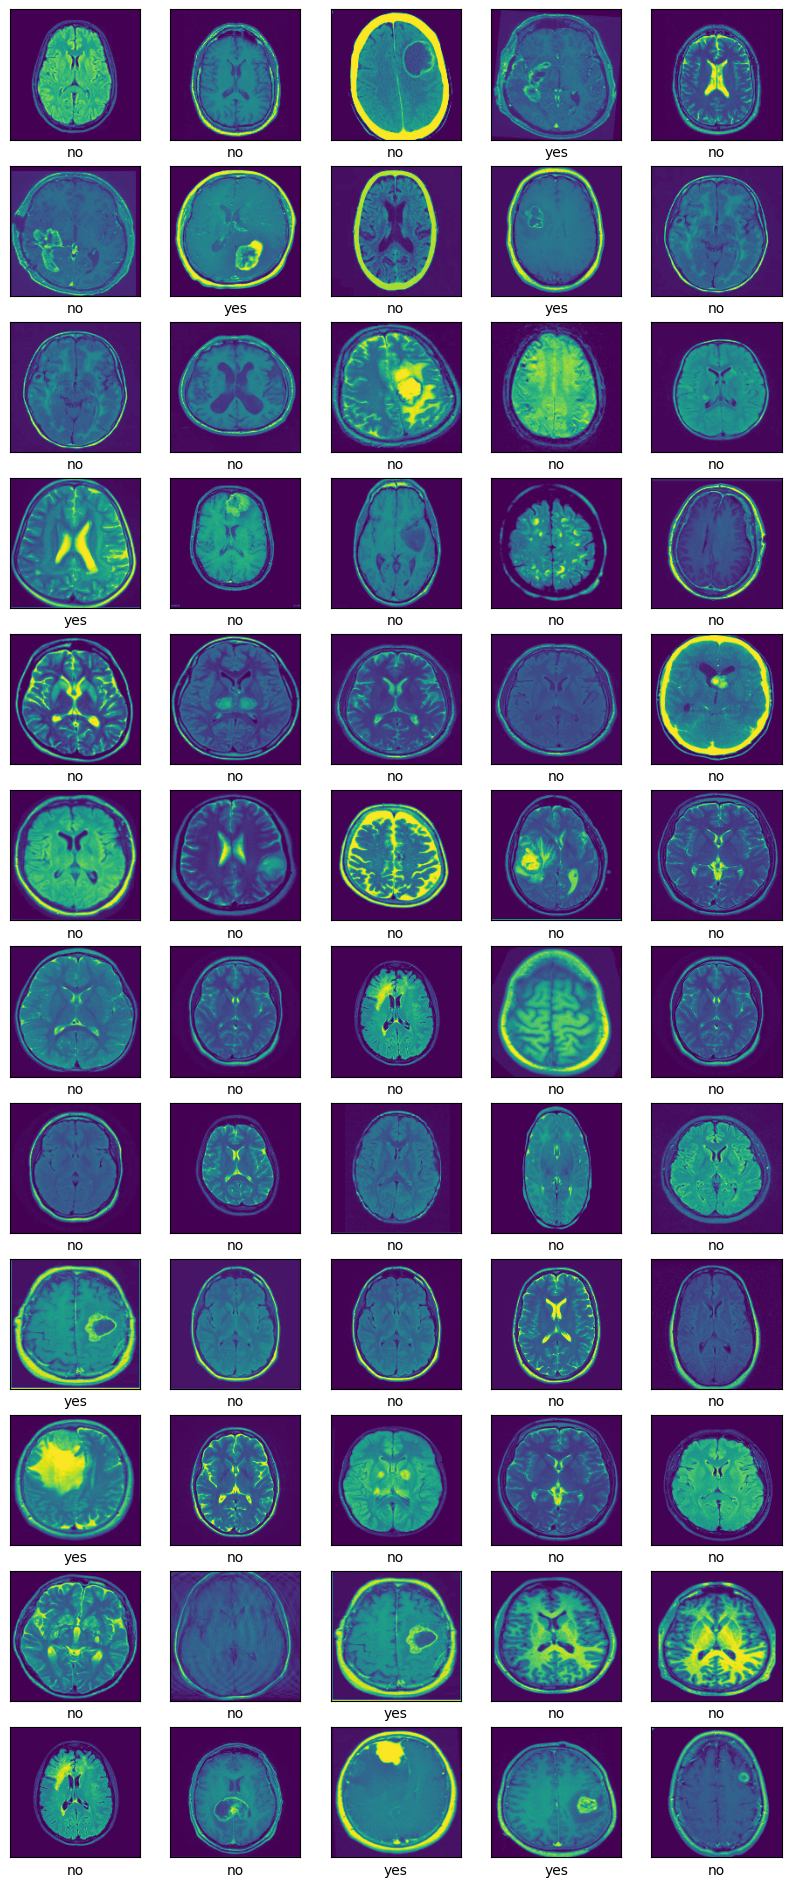

In [22]:
# making predictions

y_pred_new = model.predict(X_new)
y_pred_new = (y_pred_new >= 0.5).astype(int)

categories = ["yes","no"]

plt.figure(figsize=(10,24))
for i in range(60):
    plt.subplot(12,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_new[i])
    plt.xlabel(categories[y_pred_new[i][0]])